# Computed tomography - an introduction to image reconstruction

## What is CT

Computed tomography - typically shortened to 'CT' - is the technique by which multiple 1D or 2D projections are combined to form a 3-dimensional image. 

The first CT scanner was built in 1971 by a British electrical engineer - Sir Godfey Hounsfield. Hounsfield - along with Allan MacLeod Cormack a South African physicist who developed some of the underpinning mathematical techniques - was awarded the 1979 Nobel Prize in Medicine for this work.

Nowadays, most reasonably sized hospitals will have a CT scanner (also known as a CAT scanner) which uses X-ray projections to create three dimensional images. Tomography is also fundamental in SPECT and PET imaging and MRI - these techniques will be discussed later in this module.

Of course, CT has far wider applications than medicine and is also used regularly in manufacturing, inspection, and analysis industries. 

## Why Python?


The tasks outlined in this workshop could be carried out in many programming languages. Python does have some prewritten libraries that do some of the hard work for you but was mainly chosen as (a) it is already familiar to many of you, (b) it remains one of the most common languages to see on job listings - so more experience for you can only be a good thing, and (c) it is the basis of the analysis code you have already seen in the GATE workshop.

In practice, researchers working on imaging reconstruction will use a range of tools. Python is particularly popular when linking with machine learning. MatLab (which you will use in a future session) is common for visualisation. Quite often the language of choice is simply the language that a particular researcher or group is most familiar with!

I know some of you have very limited programming experience, and I have included a bit of additional description to help you. I am assuming that those of you who have downloaded their own version of this notebook are comfortable installing libraries etc., if you are not you should instead complete this activity through the binder link. This notebook allows you to run each cell, one by one, and see what the output is. As you are working through this sheet, try to work out what each line is doing - you can get the same result by blindly copying but you won't learn anything!

## Creating a planar projection

The first step in most Python scripts is to import the necessary packages. To start with, we need the following;

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import skimage.draw

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon
from IPython.display import clear_output

Press 'Run' (or Ctrl+Enter) to run this code block. You will be alerted to any errors, and these errors are very helpful when trying to get new code running for the first time.

If you are running it for the first time, you may need to install the relevant library. There are different ways to do this depending on how you have installed Python - if you are unsure, and can't work it out with a Google, please ask a member of staff to help.

The Shepp-Logan phantom is a standard test image based on a simplified cross section of a human head. To see what it looks like, run the code below.

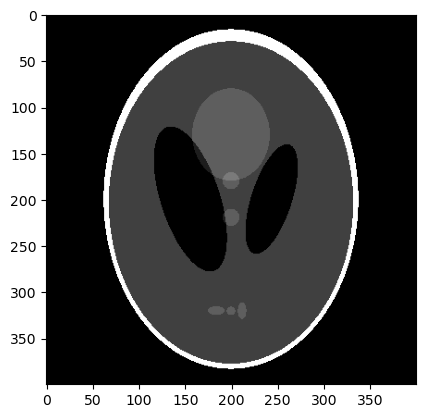

In [2]:
shepp_image = shepp_logan_phantom()
plt.imshow(shepp_image, cmap=plt.cm.Greys_r)
plt.show()

We have a bright ring representing the skull and various features representing areas of different density in the brain.

A single x-ray image is a projection through the object in a single direction. Consider a horizontal projection from left to right on the Shepp-Logan phantom. Mathematically this is

$$\lambda\left(y\right) = \int \mu\left(x\right)$$

We can do the same thing computationally, using the pixel value in the Shepp-Logan phantom as a proxy for $\mu$.

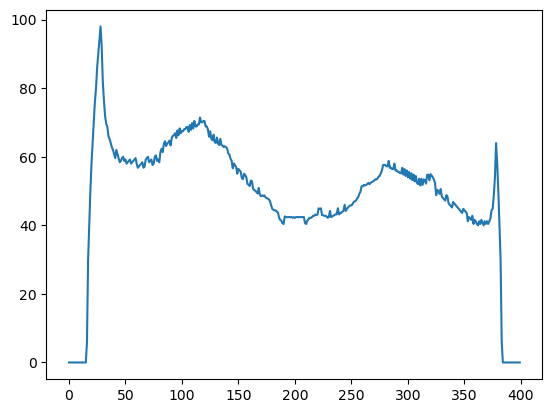

In [3]:
horizontal_proj = np.sum(shepp_image, axis = 1)
plt.plot(horizontal_proj)

In this case, you can ignore the warning - this is just because we're using a Jupyter notebook but I've written code as if it was a standalong Python script.

If you wanted to create a more intuitive plot you could use the following code to plot the images side by side.

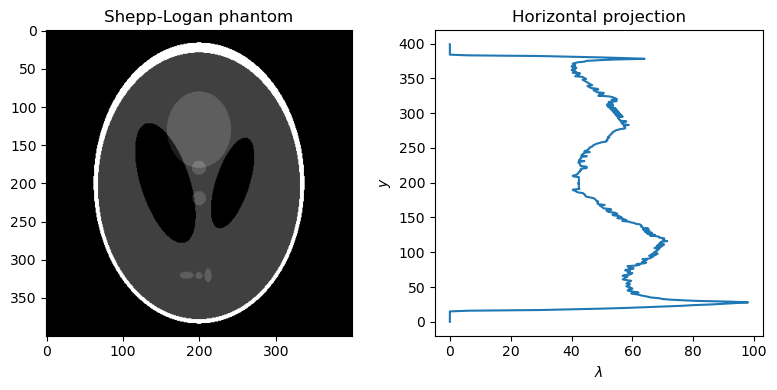

In [4]:
horizontal_proj = np.sum(shepp_image, axis = 1)
dims = shepp_image.shape

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.set_title("Shepp-Logan phantom")
ax1.imshow(shepp_image, cmap=plt.cm.Greys_r)

ax2.set_title("Horizontal projection")
ax2.set_xlabel("$\lambda$")
ax2.set_ylabel("$y$")
ax2.plot(horizontal_proj, np.arange(0,  dims[1], 1))
fig.tight_layout()

plt.show() 

Note how the images are arranged. You can find more information about how this is done in the matplotlib (the library I've used for plotting) documentation.

<div class="alert alert-block alert-info">

<b>Activity</b>
    
Use the codeblock below to also add a vertical projection to your plot
    
</div>

## The Radon Transform

The plots above are for a single projection, in practice projections will be taken at multiple angles. The skimage.transform library does the hard work for you. In the cell below, I've displayed each projection as it's generated.

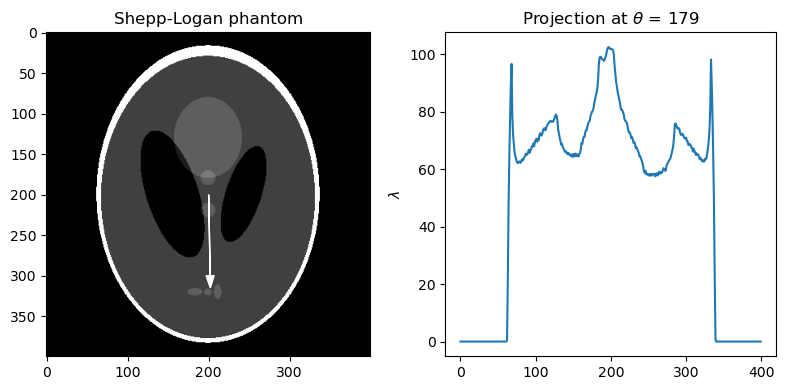

In [10]:
theta = np.arange(0, 180, 1)
sinogram = radon(shepp_image, theta=theta)

for proj in theta:
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4)) 
    ax1.set_title("Shepp-Logan phantom")
    ax1.imshow(shepp_image, cmap=plt.cm.Greys_r)
    
    ax1.arrow(200, 200, 100*np.sin(np.radians(proj)), -100*np.cos(np.radians(proj)), color="white", head_width = 10)

    ax2.set_title("Projection at $\\theta$ = %i" %proj)
    ax2.set_ylabel("$\lambda$")
    
    ax2.plot(sinogram[:,proj])
    fig.tight_layout()
    plt.show()

A more common way to display this data is as an image known as a sinogram. Each column of the sinogram is one projection - so a single one of the plots shown in the previous section. Essentially we are converting our image from object space $f\left(x, y\right)$ to projection space $g\left(\rho, \theta\right)$ where $\theta$ is the angle of the projection and $\rho$ is position perpendicular to this angle (that is, the x-axis in the figures above).

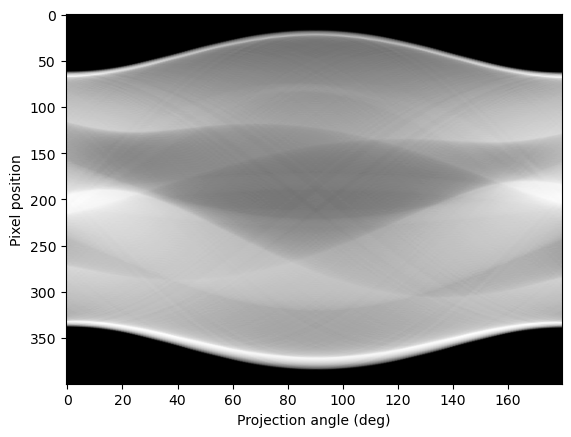

In [11]:
plt.imshow(sinogram, cmap=plt.cm.Greys_r, aspect='auto')
plt.xlabel("Projection angle (deg)")
plt.ylabel("Pixel position")
plt.show()

For a given line $L$ along the direction of our projection we have;

$$
	\begin{align}
	g\left(\rho, \theta \right) &= \int \mu\left(L\right) dL \\
	&= \int \mu\left(x, y\right) \delta L
	\end{align}
$$

The replacement of $d$ with $\delta$ simply means that we only care about the integration along $L$. From spherical coordinates we have;

$$ x\cos{\theta} + y\cos{\theta} = \rho $$

substituting this gives

$$
	\begin{align}
	g\left(\rho, \theta \right) &= \iint \mu\left(x, y\right) \delta\left(x\cos{\theta} + y\cos{\theta} - \rho \right) dxdy \\
	\end{align}
\label{eqn:radon}
$$

This result is the Radon Transform.

<div class="alert alert-block alert-info">

   <b>Activity</b>
    
Use the radon command to see how other images look as a sinogram. Start with an empty array and use the [skimage draw module](https://scikit-image.org/docs/stable/api/skimage.draw.html) to add simple shapes. How do different types of shape appear on a sinogram? How does the position of the shape change the sinogram?
    
</div>

## Image reconstruction

The sinogram is a representation of the readout of a CT scanner - in our case we have looked at a single slice but you can imagine the sinogram extending to look at multiple slices. However, unlike our demo data here, we don't actually know what the original image looked like. We need to reconstruct the image, from only the sinogram.

### Backprojection

The simplest kind of reconstruction is back projection. This is simply the inverse of the Radon Transform - we take $g$ at a specific $\theta$ and $\rho$ and populate all the $x$ and $y$ positions along the 'line of response' with this value;

$$
	\begin{align}
	F_{\theta} \left(x, y\right) &= g \left(\rho, \theta\right)\\
	&=  g \left(x\cos{\theta} + y\cos{\theta}, \theta\right)
	\end{align}
$$

We then repeat this for each angular projection:

$$
	\begin{align}
		F \left(x, y\right) = \sum_{\theta = 0}^{\pi} g \left(x\cos{\theta} + y\cos{\theta}, \theta\right)
	\end{align}
$$

Applying this transformation on the collected sinogram data we get;

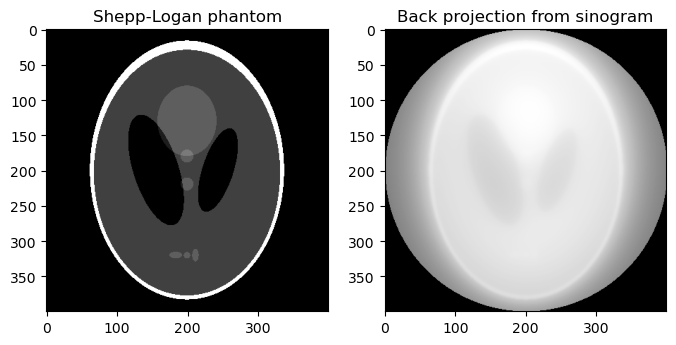

In [13]:
back_projection = iradon(sinogram, theta, filter_name=None)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.set_title("Shepp-Logan phantom")
ax1.imshow(shepp_image, cmap=plt.cm.Greys_r)

ax2.set_title("Back projection from sinogram")
ax2.imshow(back_projection, cmap=plt.cm.Greys_r)

plt.show()

Clearly there is imaging information there but it's not ideal! Blurring of the image is to be expected - we are averaging/smearing along a line of response after all - and there is also an issue with oversampling in the centre as we can only acquire discrete slices. To improve our reconstruction, we need some more maths!

<div class="alert alert-block alert-info">

   <b>Activity</b>
    
 The central oversampling effect becomes more obvious when working with fewer projections. Adapt the code provided to investigate this effect. You will begin to see star artefacts, characteristic of simple back projection - these might be more obvious on one of your phantom designs than the Shepp-Logan phantom. Can you produce an animation which shows this in action?
    
</div>


### Fourier slice theorem

The problems we see with a simple backprojection can be overcome if we apply the reconstruction in the frequency rather than spatial domain. To do this, you will need a bit of a refresher on Fourier transforms.

Fourier transforms are based on the principle that any function can be described by the sum an (infinite) series of sinusoids of different frequencies. The general and reversable form of the Fourier transform is

$$
	\begin{align}
		F\left(k\right) &= \int_{-\infty}^{+\infty} f\left(x\right)e^{-2\pi ikx}dk \\
		f\left(x\right) &= \int_{-\infty}^{+\infty} F\left(k\right)e^{2\pi ikx}dk
	\end{align}
$$

where by convention the function in the spatial domain $f\left(x\right)$ is lower case and the upper case $F\left(k\right)$is the frequency domain.

In the case of our sinogram $g$, the Fourier transform is;

$$
	\begin{align}
	& G\left(\omega, \theta\right) = \int_{-\infty}^{+\infty} g\left(\rho, \theta\right)e^{-2\pi j \omega \rho}d\rho
    \end{align}
$$

Note that in the equation above I have also changed the variable names from those you have likely encountered in maths modules to those more typical in the field of image reconstruction - there is no mathematical difference here, it's just a change in the most common terminology.

Once again we return to the Radon transform and substitute 

$$
	\begin{align}
	G\left(\omega, \theta\right) &= \iiint \mu\left(x, y\right) \delta\left(x \cos{\theta} + y\cos{\theta} - \rho \right) dxdy \; e^{-2\pi j \omega \rho}d\rho \\
	&= \iint \mu\left(x, y\right) \int \delta\left(x \cos{\theta} + y\cos{\theta} - \rho \right) \; d\rho \; dxdy
	\end{align}
$$

As $\left(x \cos{\theta} + y\cos{\theta} - \rho \right)$ is either 1 (on the line, where $\left(x \cos{\theta} + y\cos{\theta} = \rho \right)$) or 0 (everywhere else) this simplifies to

$$
	\begin{align}
		G\left(\omega, \theta\right) = \iint \mu\left(x, y\right) e^{-2 \pi j \omega \left[x \cos{\theta} + y\cos{\theta}\right]} dxdy
	\end{align}
$$

Using the common transforms

$$
	\begin{align}
		u &= \omega \cos{\theta}\\
		v &= \omega \sin{\theta}
	\end{align}
$$

results in

$$
	\begin{align}
		\iint \mu\left(x, y\right) e^{-2 \pi j \omega \left[ux + vy \right]} dxdy = M\left(u, v\right)
	\end{align}
\label{eq:FLT}
$$

That is, we can convert from a 1D Fourier transform of $g$ to a 2D Fourier transform of $\mu$!

This results is known as the Fourier slice theorem (also the projection slice theorem, and central slice theorem)and remains true for higher dimensions.

### Filtered back projection

I hope you will agree that this provides a neat and satisfying result, but why does it matter?

Now that we have image information in the frequency domain, we filter the information in that domain prior to back projection.

The blurring seen with raw back projection is a form of low frequency noise and can be corrected with a low frequency filter. In fact, the blurring seen can be shown to follow a $1/r$ - where $r$ is the distance from a hot spot. To counteract this, we apply a ramp filter (linear in frequency space), which suppresses low frequency data relative to high frequency data.

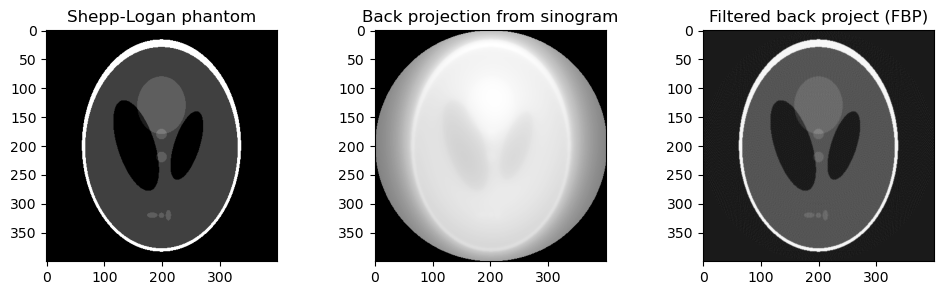

In [15]:
back_projection_ramp = iradon(sinogram, theta, filter_name='ramp')

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3))
ax1.set_title("Shepp-Logan phantom")
ax1.imshow(shepp_image, cmap=plt.cm.Greys_r)

ax2.set_title("Back projection from sinogram")
ax2.imshow(back_projection, cmap=plt.cm.Greys_r)

ax3.set_title("Filtered back project (FBP)")
ax3.imshow(back_projection_ramp, cmap=plt.cm.Greys_r)
plt.show()

<div class="alert alert-block alert-info">

   <b>Activity</b>
    
It is often useful to investigate errors in reconstruction. An 'average' error may give a gross comparison of different reconstructions but, as we have seen, different structures in an image may display different types of error. One way to visualise this is to subtract the original (ground truth) image from the FBP image and to display this as an image. It can also be helpful to understand the magnitude of the errors e.g. the maximum and median deviation from the true image, either over the whole image or just a region of interest (the numpy package can help with this).
    
1. How does the number of projections affect the reconstruction error?
2. There are a number of other preloaded filters. How do 'cosine' or 'hann' compare to the 'ramp' filter? You can find the shape of these filters online, can you explain what they are doing in words?
</div>

## Noise: a very limited introduction

In reality, the images obtained will not be a perfect integral along our lines of response. One factor that will effect image quality is detector noise. We can simulate this by adding some random noise to the sinogram.

In [16]:
from skimage.util import random_noise

noisy_sinogram = random_noise(sinogram, mode='gaussian', var = 10, clip=False)

<div class="alert alert-block alert-info">

<b>Activity</b>

1. How does noise impact the reconstructed images for each filter? Pay particular attention to the smallest image features.
2. Here we are simply adding random digital noise to the image. What other sources of error and uncertainty can you envisage happening in practice (you might want to consider the nature of X-rays, the patient, and the CT scanner itself). How might these different effects impact the reconstructed image?
3. Image reconstruction gets far more complex than filtered back projection. Research some more advanced techniques and their performance. What challenges are researchers trying to address?
4. Assessing image quality is not as straight forward as it might appear! Research some quantitative metrics of image quality, and see if you can apply them to investigate the performance of the different reconstructions.

</div>